# Modeling and Evaluation Notebook

## Objectives

*   Answer business requirement 2: 
    * The client is interested to tell whether a given cell contains malaria parasite or not.


## Inputs

* inputs/malaria_dataset/cell_images/train
* inputs/malaria_dataset/cell_images/test
* inputs/malaria_dataset/cell_images/validation
* image shape embeddings

## Outputs
* Images distribution plot in train, validation, and test set
* Image augmentation
* Class indices to change prediction inference in labels
* Machine learning model creation and training
* Save model
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on the random image file




## Additional Comments | Insights | Conclusions




---

---

# Import regular packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Set Working Directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/WalkthroughProject01')
print("You set a new current directory")

You set a new current directory


In [4]:

work_dir = os.getcwd()
work_dir

'/workspace/WalkthroughProject01'

---

## Set input directories

Set train, validation and test paths

In [5]:
my_data_dir = 'inputs/test/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [6]:
version = 'v1'
file_path = f'outputsTest/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputsTest'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


## Set labels

In [7]:

labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
    )

Project Labels: ['healthy', 'powdery_mildew']


## Set image shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputsTest/{version}/image_shape.pkl")
image_shape

(50, 50, 3)

---

# Number of images in train, test and validation data

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




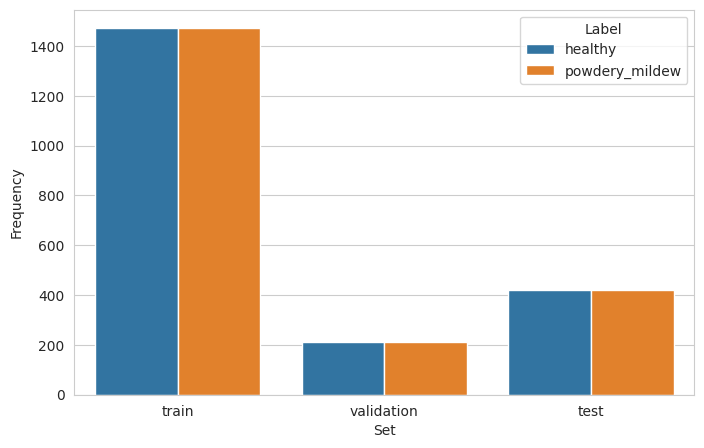

In [9]:
df_freq = pd.DataFrame([]) 
for folder in ['train', 'validation', 'test']:
  for label in labels:
    df_freq = df_freq.append(
        pd.Series(data={'Set': folder,
                        'Label': label,
                        'Frequency':int(len(os.listdir(my_data_dir+'/'+ folder + '/' + label)))}
                  ),
                  ignore_index=True
        )
    
    print(f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

# Image data augmentation

---

### ImageDataGenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* ### Intiatize ImageDataGenerator

In [11]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

* ### Augment training image dataset

In [12]:
batch_size = 20 # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment validation image dataset

In [13]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment test image dataset

In [14]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented training image

(20, 50, 50, 3)


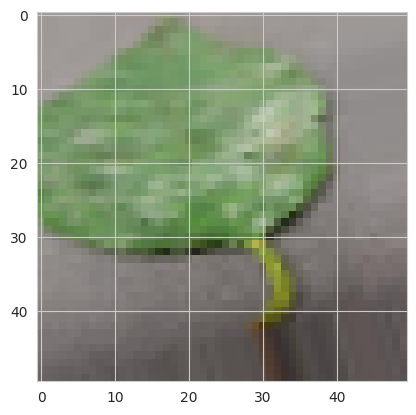

(20, 50, 50, 3)


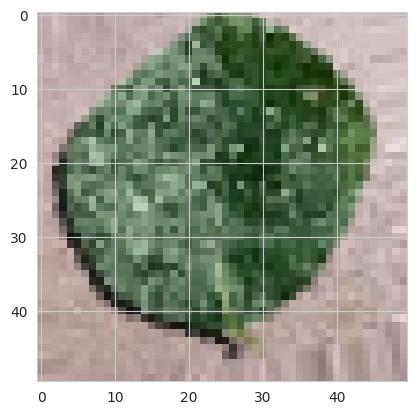

(20, 50, 50, 3)


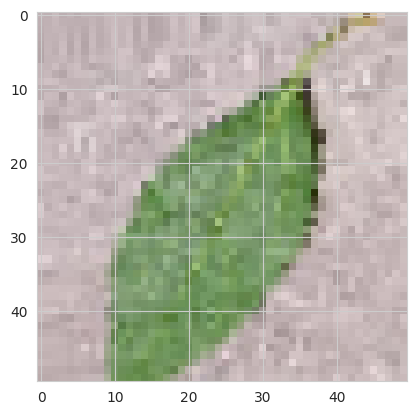

In [15]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Plot augmented validation and test images

(20, 50, 50, 3)


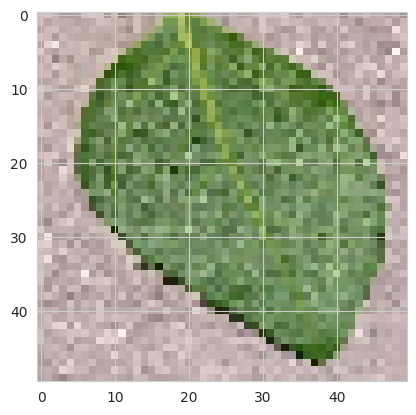

(20, 50, 50, 3)


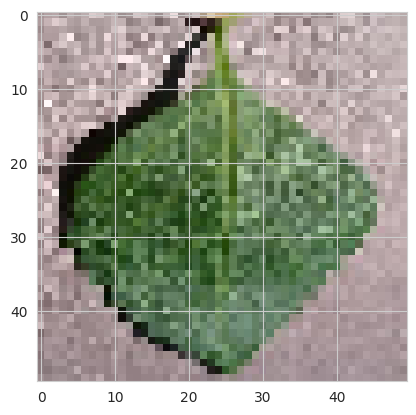

(20, 50, 50, 3)


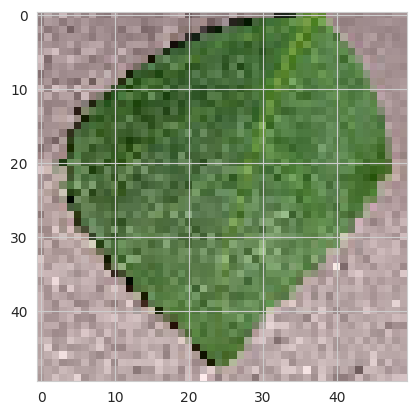

In [16]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 50, 50, 3)


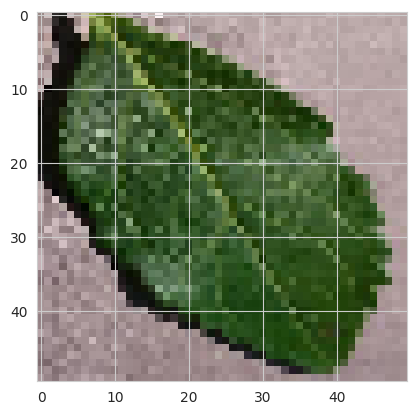

(20, 50, 50, 3)


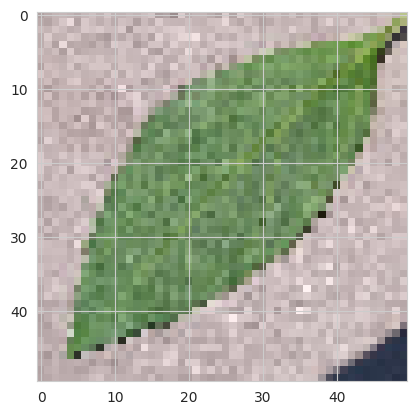

(20, 50, 50, 3)


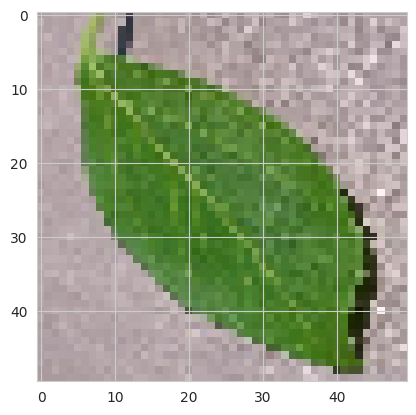

In [17]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Save class_indices

In [18]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputsTest/v1/class_indices.pkl']

---

# Model creation

---

## ML model

* ### Import model packages

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ### Model 

In [20]:

def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

* ### Model Summary 

In [21]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

2022-09-05 08:46:30.319722: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


* ### Early Stopping 

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

## Fit model for model training

In [23]:
model = create_tf_model()
model.fit(train_set,
          # epochs=25,
          epochs=20,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2022-09-05 08:47:41.260371: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
147/147 [==============================] - 9s 55ms/step - loss: 0.3629 - accuracy: 0.8239 - val_loss: 0.2163 - val_accuracy: 0.9119
Epoch 2/20
147/147 [==============================] - 10s 67ms/step - loss: 0.1968 - accuracy: 0.9234 - val_loss: 0.1045 - val_accuracy: 0.9738
Epoch 3/20
147/147 [==============================] - 5s 34ms/step - loss: 0.1164 - accuracy: 0.9603 - val_loss: 0.0672 - val_accuracy: 0.9857
Epoch 4/20
147/147 [==============================] - 5s 34ms/step - loss: 0.0965 - accuracy: 0.9675 - val_loss: 0.0510 - val_accuracy: 0.9905
Epoch 5/20
147/147 [==============================] - 6s 38ms/step - loss: 0.0681 - accuracy: 0.9795 - val_loss: 0.0728 - val_accuracy: 0.9833
Epoch 6/20
147/147 [==============================] - 11s 73ms/step - loss: 0.0736 - accuracy: 0.9733 - val_loss: 0.0456 - val_accuracy: 0.9881
Epoch 7/20
147/147 [==============================] - 11s 75ms/step - loss: 0.0518 - accuracy: 0.9815 - val_loss: 0.0354 - val_accuracy: 0.9

## Save model

In [25]:
model.save('outputsTest/v1/powdery_mildew_detector.h5')

---

# Model Performace

---

## Model learning curve

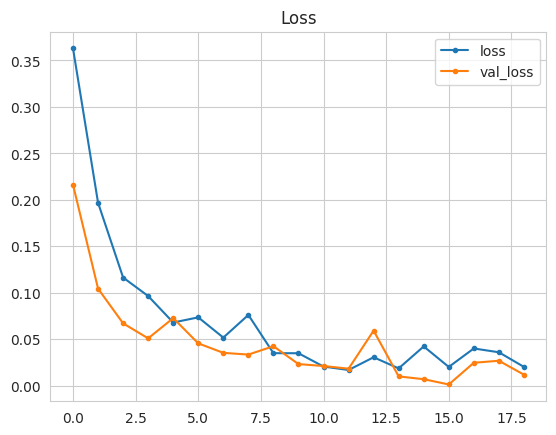

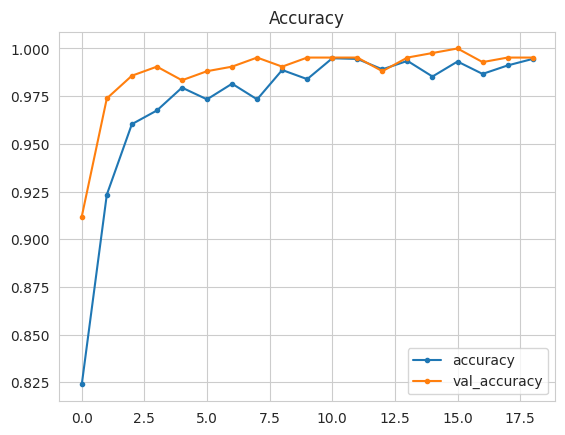

In [26]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

Load saved model

In [27]:
from keras.models import load_model
model = load_model('outputsTest/v1/powdery_mildew_detector.h5')

Evaluate model on test set

In [28]:
evaluation = model.evaluate(test_set)


43/43 [==============================] - 1s 22ms/step - loss: 0.0019 - accuracy: 0.9988


### Save evaluation pickle

In [29]:
joblib.dump(value=evaluation ,
            filename=f"outputsTest/v1/evaluation.pkl")

['outputsTest/v1/evaluation.pkl']

## Predict on new data

Load a random image as PIL

Image shape: (50, 50), Image mode: RGB


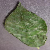

In [33]:
from tensorflow.keras.preprocessing import image

pointer = 66 
label = labels[1] # select Uninfected or Parasitized

pil_image = image.load_img(test_path + '/'+ label + '/'+ os.listdir(test_path+'/'+ label)[pointer],
                          target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [34]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 50, 50, 3)


Predict class probabilities

In [35]:
pred_proba = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class =  target_map[pred_proba > 0.5]  

if pred_class == target_map[0]: pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)


0.99999547
powdery_mildew


---

# Push files to Repo

## Push generated/new files from this Session to GitHub repo

* .gitignore

In [37]:
!cat .gitignore

inputs/malaria_dataset/cell_images/test
inputs/malaria_dataset/cell_images/train
inputs/malaria_dataset/cell_images/Uninfected
inputs/malaria_dataset/cell_images/ParasitizedS
inputs/test/cherry-leaves/test
inputs/test/cherry-leaves/train
kaggle.json
*.ipynb



* Git status

In [38]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   .gitignore
	modified:   jupyter_notebooks/01 - DataCollection.ipynb
	modified:   jupyter_notebooks/02 - DataVisualization.ipynb
	modified:   jupyter_notebooks/03 - Modelling and Evaluating.ipynb
	modified:   outputs/v1/labels_distribution.png
	modified:   outputs/v1/malaria_detector_model.h5

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	inputs/malaria_dataset/cell_images/Parasitized/
	inputs/test/
	outputs/v1/powdery_mildew_detector.h5
	outputsTest/

no changes added to commit (use "git add" and/or "git commit -a")


* Git add

In [39]:
!git add .

* Git commit

In [37]:
!git commit -am " Add Testing cherry_leaves dataset"

[main 057f7b96]  Add new plots
 1142 files changed, 1136 insertions(+), 128 deletions(-)
 create mode 100644 inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_141341_cell_153.png
 create mode 100644 inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_141341_cell_159.png
 create mode 100644 inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_141428_cell_126.png
 create mode 100644 inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_141428_cell_128.png
 create mode 100644 inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_141504_cell_150.png
 create mode 100644 inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_142109_cell_137.png
 create mode 100644 inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_142109_cell_145.png
 create mode 100644 inputs/malaria_dataset/

* Git Push

In [38]:
!git push

Enumerating objects: 1159, done.
Counting objects: 100% (1159/1159), done.
Delta compression using up to 16 threads
Compressing objects: 100% (1146/1146), done.
Writing objects: 100% (1153/1153), 31.40 MiB | 3.84 MiB/s, done.
Total 1153 (delta 3), reused 1131 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/alerebal/WalkthroughProject01.git
   0e92b681..057f7b96  main -> main


---